## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Flatten

Using TensorFlow backend.


## Dataset

In [2]:
reviews = pd.read_csv("Restaurant_Reviews.tsv", sep="\t")

In [3]:
reviews.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
Review    1000 non-null object
Liked     1000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


## Model

In [5]:
class NLP:
    
    def __init__(self, df, text_col, label_col, test_size=0.2):
        assert isinstance(df, pd.DataFrame), "ERROR: Please insert a pandas dataframe"
        X = reviews.loc[:, text_col]
        y = reviews.loc[:, label_col]

        self.__X_train, self.__X_test, \
            self.__y_train, self.__y_test = train_test_split(X, y, test_size=test_size, random_state=99)
        self.__word_index = {}
        
    def __tokenize(self, vocab_size, oov_token):
        tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
        tokenizer.fit_on_texts(self.__X_train)
        self.__word_index = tokenizer.word_index
        training_sequences = tokenizer.texts_to_sequences(self.__X_train)
        testing_sequences = tokenizer.texts_to_sequences(self.__X_test)
        
        return training_sequences, testing_sequences
    
    def __padding(self, sequences, max_length, padding_type, trunc_type):
        return pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    
    def preprocess_text(self, vocab_size, oov_token=None, max_length=None, padding_type="post", trunc_type="post"):
        if max_length is None:
            max_length = self.__X_train.apply(lambda x: len(x.split())).max()
        self.__vocab_size = vocab_size
        self.__max_length = max_length
        training_sequences, testing_sequences = self.__tokenize(vocab_size, oov_token)
        self._train = self.__padding(training_sequences, max_length, padding_type, trunc_type)
        self._test = self.__padding(testing_sequences, max_length, padding_type, trunc_type)
        print("Model input succesfully generated!")
    
    @property
    def word_index(self):
        return self.__word_index
    
    @property
    def train(self):
        return self._train
    
    @property
    def test(self):
        return self._test
    
    @property
    def train_labels(self):
        return self.__y_train
    
    @property
    def test_labels(self):
        return self.__y_test
    
    def __build_network(self, embedding_dim, loss, optimizer):
        self._model = Sequential(layers=[
            Embedding(input_dim= self.__vocab_size, output_dim=embedding_dim, input_length=self.__max_length),
            Flatten(),
            Dense(units=32, activation="relu"),
            Dense(units=1, activation="sigmoid")
        ])
        self._model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    
    @property
    def model(self):
        return self._model
    
    @property
    def model_summary(self):
        return self._model.summary()
    
    def fit(self, num_epochs, embedding_dim, loss="binary_crossentropy", optimizer="adam"):
        self.__num_epochs = num_epochs
        self.__build_network(embedding_dim, loss, optimizer)
        self._model.fit(self._train, self.__y_train, epochs=num_epochs, 
                        validation_data=(self._test, self.__y_test))
        
    def get_predictions(self, probability=False):
        if probability:
            return self._model.predict_classes(self._test), self._model.predict_proba(self._test)
        return self._model.predict_classes(self._test)
        
    def visualize_history(self):
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,5))
        x = np.linspace(1, self.__num_epochs, self.__num_epochs)
        ax1.plot(x, self._model.history.history["loss"], label="Training Loss")
        ax1.plot(x, self._model.history.history["val_loss"], label="Validation Loss")
        ax1.xaxis.set_ticks(x)
        ax1.legend()
        ax2.plot(x, self._model.history.history["accuracy"], label="Training Accuracy")
        ax2.plot(x, self._model.history.history["val_accuracy"], label="Validation Accuracy")
        ax2.xaxis.set_ticks(x)
        ax2.legend()
        plt.show()

In [6]:
review_problem = NLP(reviews, text_col="Review", label_col="Liked", test_size=0.1)

In [7]:
review_problem.preprocess_text(vocab_size=1500, oov_token="<OOV>", max_length=None, 
                               padding_type='post', trunc_type='post')

Model input succesfully generated!


In [8]:
index = {value:key for key, value in review_problem.word_index.items()}
" ".join([index[i] for i in review_problem.train[0] if i!=0])

'it was a pale color instead of nice and char and has no flavor'

In [9]:
review_problem.fit(num_epochs=20, embedding_dim=25, loss='binary_crossentropy', optimizer='adam')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 900 samples, validate on 100 samples
Epoch 1/20
900/900 [==============================] - 0s 272us/step - loss: 0.6937 - accuracy: 0.5111 - val_loss: 0.6894 - val_accuracy: 0.5300
Epoch 2/20
900/900 [==============================] - 0s 76us/step - loss: 0.6752 - accuracy: 0.6289 - val_loss: 0.6793 - val_accuracy: 0.6300
Epoch 3/20
900/900 [==============================] - 0s 107us/step - loss: 0.6314 - accuracy: 0.7867 - val_loss: 0.6440 - val_accuracy: 0.6700
Epoch 4/20
900/900 [==============================] - 0s 99us/step - loss: 0.5162 - accuracy: 0.8478 - val_loss: 0.5707 - val_accuracy: 0.7900
Epoch 5/20
900/900 [==============================] - 0s 89us/step - loss: 0.3410 - accuracy: 0.9289 - val_loss: 0.4934 - val_accuracy: 0.7100
Epoch 6/20
900/900 [==============================] - 0s 103u

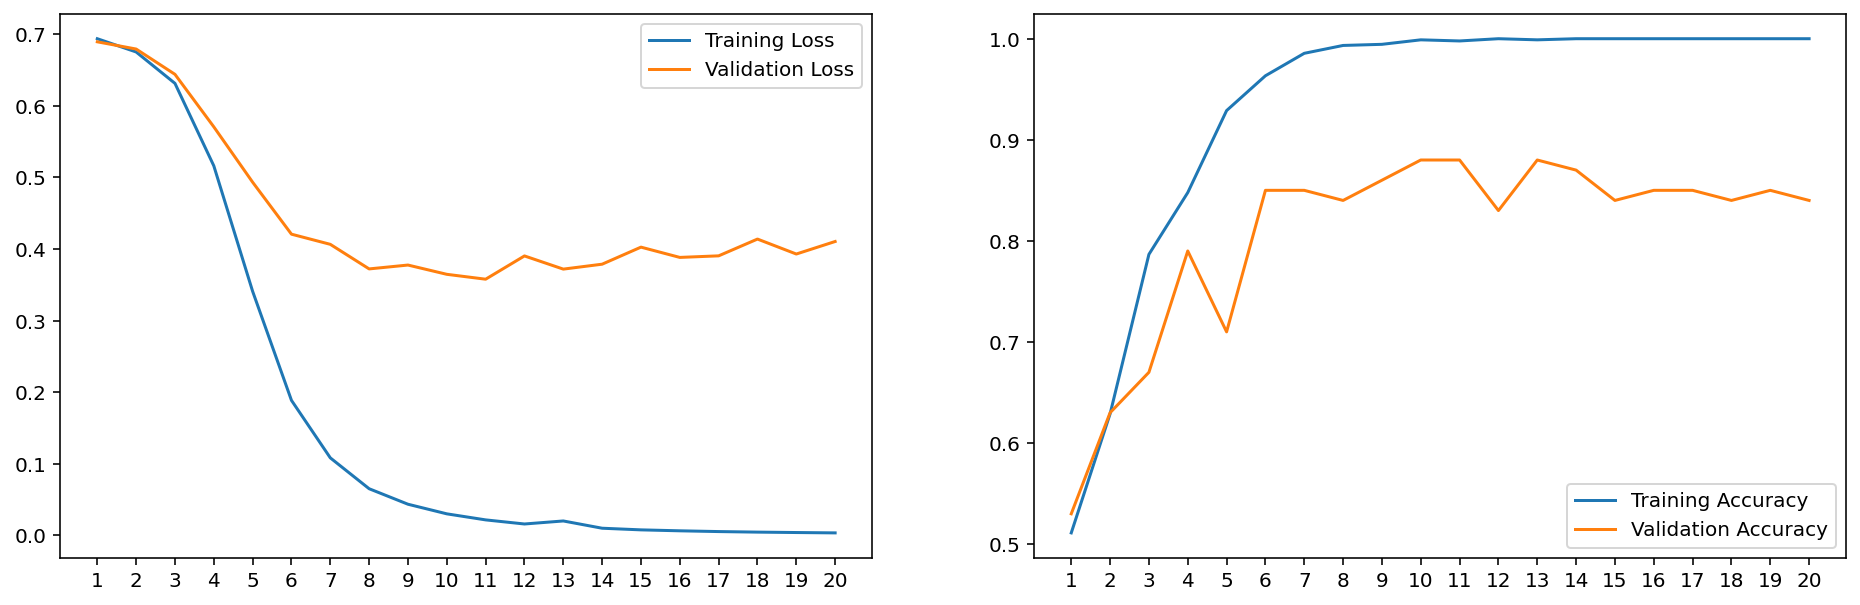

In [10]:
review_problem.visualize_history()

In [11]:
y_pred, y_proba = review_problem.get_predictions(probability=True)

## Metrics

In [12]:
print(classification_report(review_problem.test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84        47
           1       0.91      0.77      0.84        53

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



+ Confusion Matrix

In [13]:
def confusion_matrix(y_true, y_pred):    
    matrix = pd.DataFrame(data=y_true, index=y_true.index)
    matrix.rename(columns={"Liked": "Real"}, inplace=True)
    matrix["Predicted"] = y_pred
    matrix["Predicted"] = matrix["Predicted"].apply(lambda x: "Positive" if x==1 else "Negative")
    matrix["Real"] = matrix["Real"].apply(lambda x: "Positive" if x==1 else "Negative")
    return matrix.groupby(by=["Real", "Predicted"]).size().unstack()

In [14]:
confusion_matrix(review_problem.test_labels, y_pred)

Predicted,Negative,Positive
Real,,
Negative,43,4
Positive,12,41


+ ROC Curve and AUC

In [15]:
def plot_roc(y_true, probabilities):
    fpr, tpr, thresholds = roc_curve(y_true, probabilities)
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    plt.plot(fpr, tpr, color="green", label=f"SVM (AUC = {roc_auc_score(y_true, probabilities):.3f})")
    plt.plot([0,1], [0,1], color="navy")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.xlim((0,1))
    plt.ylim((0,1.001))
    plt.legend(loc=4)
    plt.show()

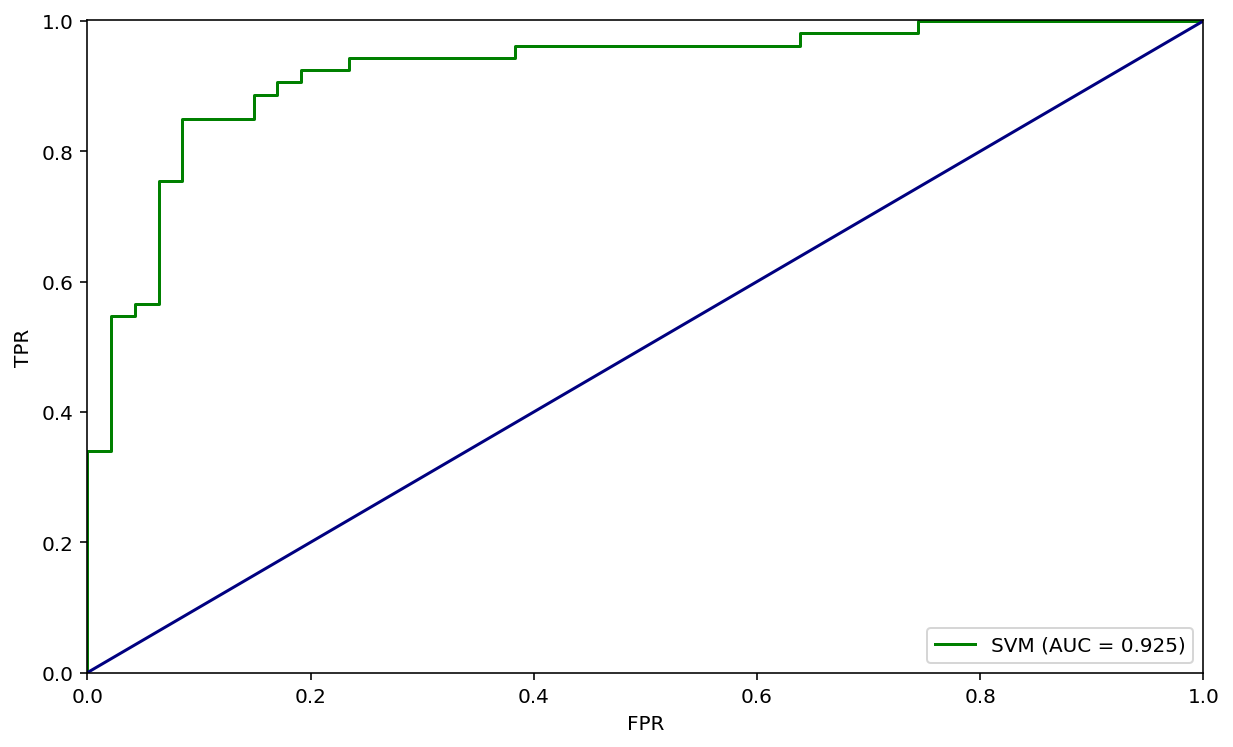

In [16]:
plot_roc(review_problem.test_labels, y_proba)

+ CAP

In [17]:
def plot_cap(y_true, probabilities):    
    base = pd.DataFrame(data=y_true, index=y_true.index)
    base.rename(columns={"Liked": "Real"}, inplace=True)
    base["Probability"] = probabilities
    total = len(base[base.Real==1])
    
    perfect = (base.sort_values(by="Real", ascending=False)["Real"].cumsum()/total).values
    model = (base.sort_values(by="Probability", ascending=False)["Real"].cumsum()/total).values
    perfect = np.concatenate([[0], perfect])
    model = np.concatenate([[0], model])
    
    x = np.linspace(0, len(base), len(base)+1)/len(base)
    
    max_area = 0
    actual_area = 0
    h = x[1]-x[0]
    for i, (m, a) in enumerate(zip(perfect, model)):
        try:
            max_area+=((m-x[i])+(perfect[i-1]-(x[i-1])))*h/2
            actual_area+=((a-x[i])+(model[i-1]-(x[i-1])))*h/2
        except:
            continue
    accuracy_ratio = actual_area/max_area
    
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    plt.plot(x, model, color="green", label=f"SVM (AR = {accuracy_ratio:.3f})")
    plt.plot(x, perfect, color="red", label="Perfect Model")
    plt.plot([0,1], [0,1], color="navy")
    plt.xlabel("Reviews")
    plt.ylabel("Positive Reviews")
    plt.xlim((0,1))
    plt.ylim((0,1.01))
    plt.legend(loc=4)
    plt.show()
    
    return model, perfect, x

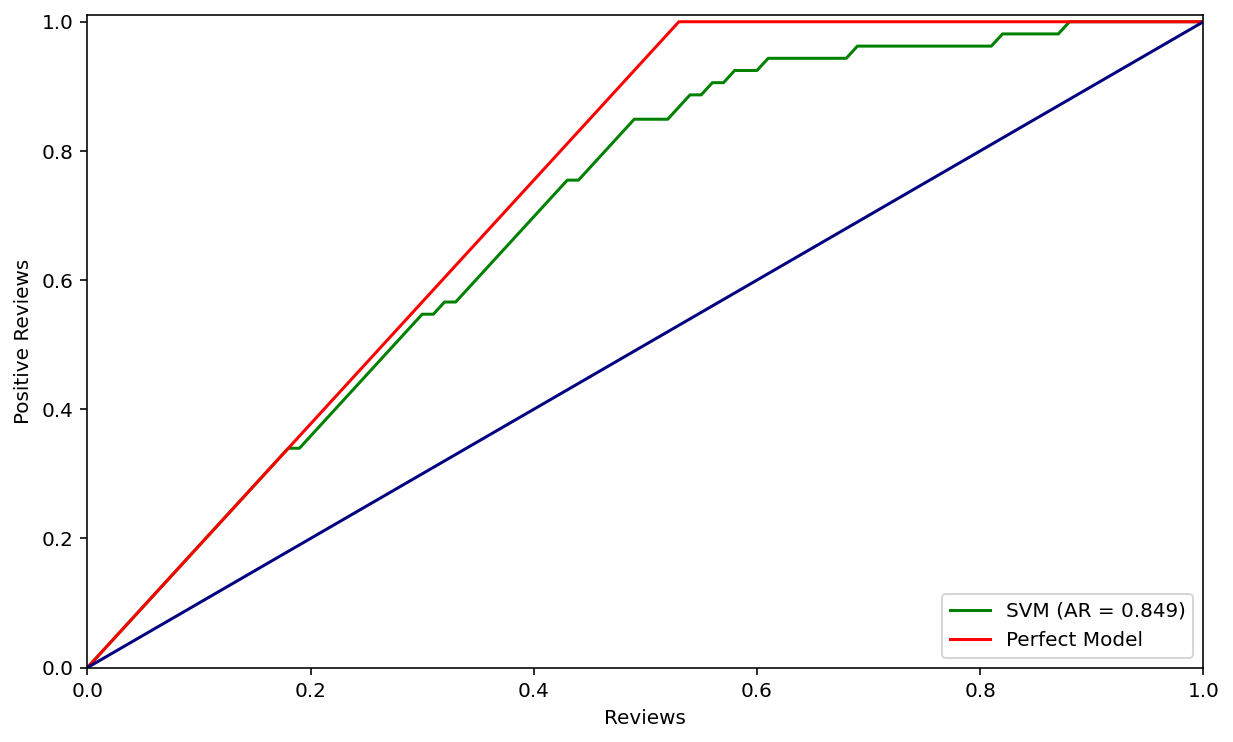

In [18]:
cap_model, cap_perfect, cap_x = plot_cap(review_problem.test_labels, y_proba)

In [19]:
cap_model[np.where(cap_x==0.5)][0]

0.8490566037735849